## 1.Setting Up

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math

# EffDet Imports
from effdet import get_efficientdet_config, EfficientDet, DetBenchPredict, DetBenchTrain
from effdet.efficientdet import HeadNet


# 1. CONFIGURATION
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 50
BATCH_SIZE = 4   
LEARNING_RATE = 2e-4
NUM_CLASSES = 3


# PATHS
TRAIN_ROOT = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\images\train'
TRAIN_ANN  = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\annotations\train.json'
VAL_ROOT   = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\images\val'
VAL_ANN    = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\annotations\val.json'


# OUTPUT FOLDERS
RUN_DIR = "runs/viewing_angle_final"
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")

os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
print(f"Running on: {DEVICE}")
print(f"Checkpoints will be saved to: {CKPT_DIR}")


# 2. DATA TRANSFORMS
class ComposeDetection:
    def __init__(self, transforms, target_size=(512, 512)):
        self.transforms = transforms
        self.target_size = target_size

    def __call__(self, image, target):
        image = ImageOps.exif_transpose(image)
        w_orig, h_orig = image.size
        
        # Resize
        image = F.resize(image, self.target_size)
        
        # Scale Boxes
        w_new, h_new = self.target_size
        scale_w = w_new / w_orig
        scale_h = h_new / h_orig
        
        new_target = []
        for t in target:
            t_copy = t.copy()
            x, y, w, h = t['bbox']
            t_copy['bbox'] = [x * scale_w, y * scale_h, w * scale_w, h * scale_h]
            new_target.append(t_copy)

        for t in self.transforms:
            image = t(image)
        return image, new_target

norm_transforms = [
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]


# 3. HELPER FUNCTIONS
def collate_fn(batch):
    return tuple(zip(*batch))

def convert_coco_target(target_list):
    boxes = []
    labels = []
    for ann in target_list:
        x, y, w, h = ann['bbox']
        boxes.append([x, y, x + w, y + h])  
        labels.append(ann['category_id']) 
        
    if len(boxes) == 0:
        boxes = torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.zeros((0,), dtype=torch.int64)
    else:
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
    return {"bbox": boxes, "cls": labels}

def prepare_batch_targets(targets, device):
    max_num_dets = max(max(t['bbox'].shape[0] for t in targets), 1)
    batch_bboxes = []
    batch_classes = []

    for t in targets:
        num_dets = t['bbox'].shape[0]
        if num_dets > 0:
            boxes_yxyx = t['bbox'][:, [1, 0, 3, 2]]
        else:
            boxes_yxyx = torch.zeros((0, 4), dtype=torch.float32)

        padded_box = torch.full((max_num_dets, 4), -1.0, dtype=torch.float32)
        padded_cls = torch.full((max_num_dets,), -1.0, dtype=torch.float32)

        if num_dets > 0:
            padded_box[:num_dets] = boxes_yxyx
            padded_cls[:num_dets] = t['cls'].float()

        batch_bboxes.append(padded_box)
        batch_classes.append(padded_cls)

    return {
        "bbox": torch.stack(batch_bboxes).to(device),
        "cls": torch.stack(batch_classes).to(device),
        "img_scale": torch.ones((len(targets), 1)).to(device),
        "img_size": torch.tensor([(512, 512)] * len(targets)).to(device),
    }


# 4. LOAD DATA (CORRECTED)
print("Loading Data...")

train_dataset = CocoDetection(
    root=TRAIN_ROOT, 
    annFile=TRAIN_ANN, 
    transforms=ComposeDetection(norm_transforms)
)

val_dataset = CocoDetection(
    root=VAL_ROOT, 
    annFile=VAL_ANN, 
    transforms=ComposeDetection(norm_transforms) 
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

print(f"Data Loaded Successfully. Train: {len(train_dataset)}, Val: {len(val_dataset)}")


# 5. SETUP MODEL
print("Initializing EfficientDet...")
config = get_efficientdet_config('tf_efficientdet_d0')
config.num_classes = NUM_CLASSES
config.image_size = (512, 512)

net = EfficientDet(config, pretrained_backbone=True)
net.class_net = HeadNet(config, num_outputs=config.num_classes)
model = DetBenchTrain(net, config)
model.to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)

c:\Users\matth\.venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda
Checkpoints will be saved to: runs/viewing_angle_final\checkpoints
Loading Data...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Data Loaded Successfully. Train: 604, Val: 133
Initializing EfficientDet...


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


## 2. Model Training

In [ ]:
# 6. TRAINING LOOP
best_val_loss = float("inf")
print(f"Starting Training for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):

    model.train()
    epoch_loss = 0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = torch.stack([img.to(DEVICE) for img in images], dim=0)
        target_list = [convert_coco_target(t) for t in targets]
        target_batch = prepare_batch_targets(target_list, DEVICE)
        
        optimizer.zero_grad()
        loss_dict = model(images, target_batch)
        loss = loss_dict["loss"]
        
        if torch.isnan(loss): continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        epoch_loss += loss.item()
        
    train_loss = epoch_loss / len(train_loader)
    

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = torch.stack([img.to(DEVICE) for img in images], dim=0)
            target_list = [convert_coco_target(t) for t in targets]
            target_batch = prepare_batch_targets(target_list, DEVICE)
            loss_dict = model(images, target_batch)
            val_loss += loss_dict["loss"].item()
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(RUN_DIR, "best_model.pth"))
        print("   ⭐ Saved New Best Model")


    if (epoch + 1) % 2 == 0:
        ckpt_name = f"model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), os.path.join(CKPT_DIR, ckpt_name))
        print(f"   💾 Saved Checkpoint: {ckpt_name}")


torch.save(model.state_dict(), os.path.join(RUN_DIR, "last_model.pth"))
print(f"Training Complete! Checkpoints are in {CKPT_DIR}")

Starting Training for 50 epochs...
Epoch 1/50 | Train Loss: 630.9308 | Val Loss: 702.5402
   ⭐ Saved New Best Model
Epoch 2/50 | Train Loss: 191.5446 | Val Loss: 111.4126
   ⭐ Saved New Best Model
   💾 Saved Checkpoint: model_epoch_2.pth
Epoch 3/50 | Train Loss: 15.6338 | Val Loss: 2.1136
   ⭐ Saved New Best Model
Epoch 4/50 | Train Loss: 1.2125 | Val Loss: 0.9776
   ⭐ Saved New Best Model
   💾 Saved Checkpoint: model_epoch_4.pth
Epoch 5/50 | Train Loss: 0.7899 | Val Loss: 0.7480
   ⭐ Saved New Best Model
Epoch 6/50 | Train Loss: 0.6461 | Val Loss: 0.6682
   ⭐ Saved New Best Model
   💾 Saved Checkpoint: model_epoch_6.pth
Epoch 7/50 | Train Loss: 0.5588 | Val Loss: 0.6187
   ⭐ Saved New Best Model
Epoch 8/50 | Train Loss: 0.4963 | Val Loss: 0.5692
   ⭐ Saved New Best Model
   💾 Saved Checkpoint: model_epoch_8.pth
Epoch 9/50 | Train Loss: 0.4430 | Val Loss: 0.5352
   ⭐ Saved New Best Model
Epoch 10/50 | Train Loss: 0.3973 | Val Loss: 0.5053
   ⭐ Saved New Best Model
   💾 Saved Checkpoint

## 3. Model Evaluation

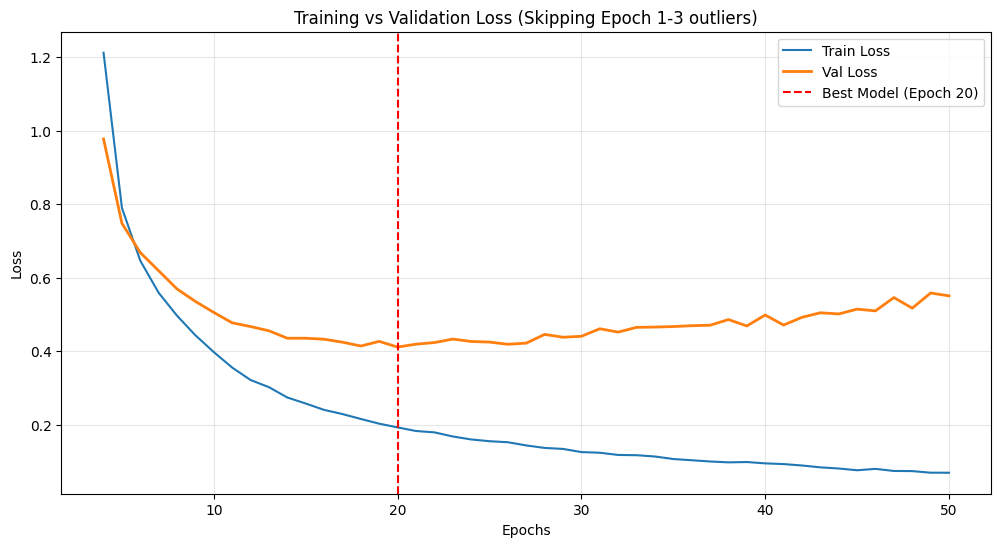

In [ ]:
import matplotlib.pyplot as plt
import re


log_data = """
Epoch 1/50 | Train Loss: 630.9308 | Val Loss: 702.5402
Epoch 2/50 | Train Loss: 191.5446 | Val Loss: 111.4126
Epoch 3/50 | Train Loss: 15.6338 | Val Loss: 2.1136
Epoch 4/50 | Train Loss: 1.2125 | Val Loss: 0.9776
Epoch 5/50 | Train Loss: 0.7899 | Val Loss: 0.7480
Epoch 6/50 | Train Loss: 0.6461 | Val Loss: 0.6682
Epoch 7/50 | Train Loss: 0.5588 | Val Loss: 0.6187
Epoch 8/50 | Train Loss: 0.4963 | Val Loss: 0.5692
Epoch 9/50 | Train Loss: 0.4430 | Val Loss: 0.5352
Epoch 10/50 | Train Loss: 0.3973 | Val Loss: 0.5053
Epoch 11/50 | Train Loss: 0.3552 | Val Loss: 0.4770
Epoch 12/50 | Train Loss: 0.3213 | Val Loss: 0.4669
Epoch 13/50 | Train Loss: 0.3018 | Val Loss: 0.4553
Epoch 14/50 | Train Loss: 0.2737 | Val Loss: 0.4351
Epoch 15/50 | Train Loss: 0.2573 | Val Loss: 0.4351
Epoch 16/50 | Train Loss: 0.2400 | Val Loss: 0.4324
Epoch 17/50 | Train Loss: 0.2286 | Val Loss: 0.4243
Epoch 18/50 | Train Loss: 0.2153 | Val Loss: 0.4139
Epoch 19/50 | Train Loss: 0.2024 | Val Loss: 0.4265
Epoch 20/50 | Train Loss: 0.1923 | Val Loss: 0.4110
Epoch 21/50 | Train Loss: 0.1825 | Val Loss: 0.4189
Epoch 22/50 | Train Loss: 0.1788 | Val Loss: 0.4233
Epoch 23/50 | Train Loss: 0.1676 | Val Loss: 0.4328
Epoch 24/50 | Train Loss: 0.1595 | Val Loss: 0.4263
Epoch 25/50 | Train Loss: 0.1547 | Val Loss: 0.4246
Epoch 26/50 | Train Loss: 0.1519 | Val Loss: 0.4186
Epoch 27/50 | Train Loss: 0.1432 | Val Loss: 0.4218
Epoch 28/50 | Train Loss: 0.1364 | Val Loss: 0.4455
Epoch 29/50 | Train Loss: 0.1337 | Val Loss: 0.4378
Epoch 30/50 | Train Loss: 0.1251 | Val Loss: 0.4404
Epoch 31/50 | Train Loss: 0.1233 | Val Loss: 0.4609
Epoch 32/50 | Train Loss: 0.1173 | Val Loss: 0.4518
Epoch 33/50 | Train Loss: 0.1166 | Val Loss: 0.4647
Epoch 34/50 | Train Loss: 0.1131 | Val Loss: 0.4655
Epoch 35/50 | Train Loss: 0.1062 | Val Loss: 0.4669
Epoch 36/50 | Train Loss: 0.1029 | Val Loss: 0.4692
Epoch 37/50 | Train Loss: 0.0995 | Val Loss: 0.4705
Epoch 38/50 | Train Loss: 0.0971 | Val Loss: 0.4859
Epoch 39/50 | Train Loss: 0.0980 | Val Loss: 0.4685
Epoch 40/50 | Train Loss: 0.0944 | Val Loss: 0.4983
Epoch 41/50 | Train Loss: 0.0924 | Val Loss: 0.4710
Epoch 42/50 | Train Loss: 0.0886 | Val Loss: 0.4920
Epoch 43/50 | Train Loss: 0.0835 | Val Loss: 0.5044
Epoch 44/50 | Train Loss: 0.0804 | Val Loss: 0.5012
Epoch 45/50 | Train Loss: 0.0756 | Val Loss: 0.5143
Epoch 46/50 | Train Loss: 0.0794 | Val Loss: 0.5096
Epoch 47/50 | Train Loss: 0.0737 | Val Loss: 0.5459
Epoch 48/50 | Train Loss: 0.0733 | Val Loss: 0.5170
Epoch 49/50 | Train Loss: 0.0690 | Val Loss: 0.5582
Epoch 50/50 | Train Loss: 0.0689 | Val Loss: 0.5505
"""

# Extract data
train_loss = []
val_loss = []
epochs = []

for line in log_data.strip().split('\n'):
    if "Train Loss" in line:
        parts = line.split('|')
        ep = int(re.search(r'Epoch (\d+)', parts[0]).group(1))
        tl = float(re.search(r'Train Loss: ([\d.]+)', parts[1]).group(1))
        vl = float(re.search(r'Val Loss: ([\d.]+)', parts[2]).group(1))
        epochs.append(ep)
        train_loss.append(tl)
        val_loss.append(vl)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epochs[3:], train_loss[3:], label='Train Loss') # Skip first few epochs to see detail
plt.plot(epochs[3:], val_loss[3:], label='Val Loss', linewidth=2)
plt.axvline(x=20, color='r', linestyle='--', label='Best Model (Epoch 20)')
plt.title("Training vs Validation Loss (Skipping Epoch 1-3 outliers)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Loading model from: runs/viewing_angle_final/best_model.pth


C:\Users\matth\AppData\Local\Temp\ipykernel_10452\1196308004.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=DEVICE)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Running Evaluation on Validation Set...

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

       Front       0.89      0.91      0.90        35
        Side       0.89      0.89      0.89        57
        Rear       0.85      0.83      0.84        41

    accuracy                           0.88       133
   macro avg       0.88      0.88      0.88       133
weighted avg       0.88      0.88      0.88       133



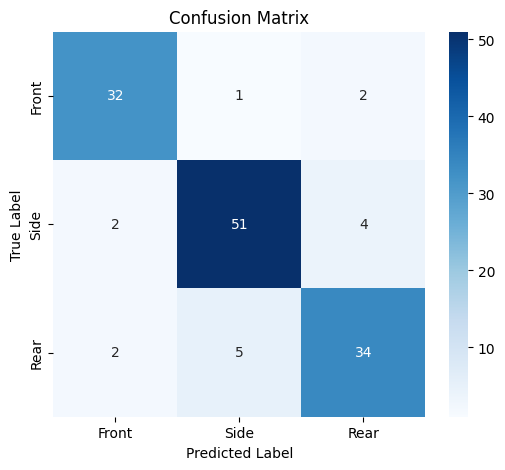

In [ ]:
# 1. SETUP & CONFIG
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3 
CLASSES = ["Background","Back","Front","Side"] # Index 0 is background
VAL_ROOT   = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\images\val'
VAL_ANN    = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\annotations\val.json'
MODEL_PATH = "runs/viewing_angle_final/best_model.pth" # Loading the BEST model (Epoch 20)

print(f"Loading model from: {MODEL_PATH}")

# 2. MODEL LOADING
def load_model(path):
    config = get_efficientdet_config('tf_efficientdet_d0')
    config.num_classes = NUM_CLASSES
    config.image_size = (512, 512)
    
    # Re-create the structure
    net = EfficientDet(config, pretrained_backbone=False)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    
    # Helper to load weights
    checkpoint = torch.load(path, map_location=DEVICE)

    bench_train = DetBenchTrain(net, config)
    bench_train.load_state_dict(checkpoint)
    
    bench_predict = DetBenchPredict(net)
    bench_predict.to(DEVICE)
    bench_predict.eval()
    return bench_predict

model = load_model(MODEL_PATH)


# 3. DATA SETUP 
class ComposeDetection:
    def __init__(self, transforms, target_size=(512, 512)):
        self.transforms = transforms
        self.target_size = target_size

    def __call__(self, image, target):
        image = ImageOps.exif_transpose(image)
        image = F.resize(image, self.target_size)

        w_orig, h_orig = image.size 
        
        # Simple transform just for the image tensor
        for t in self.transforms:
            image = t(image)
        return image, target

def collate_fn(batch): return tuple(zip(*batch))

norm_transforms = [T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

val_dataset = CocoDetection(VAL_ROOT, VAL_ANN, transforms=ComposeDetection(norm_transforms))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


# 4. METRICS CALCULATION
print("Running Evaluation on Validation Set...")

y_true = []
y_pred = []
iou_threshold = 0.5
conf_threshold = 0.3

def calculate_iou(box1, box2):
    # box: [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

with torch.no_grad():
    for images, targets in val_loader:
        images = torch.stack([img.to(DEVICE) for img in images])
        outputs = model(images) 
        
        for i in range(len(images)):
            gt_anns = targets[i]
            preds = outputs[i]
            
            # Get GT boxes and labels
            gt_boxes = []
            gt_labels = []
            for ann in gt_anns:
                x, y, w, h = ann['bbox']

                gt_labels.append(ann['category_id'])

            # Filter Predictions
            valid_preds = preds[preds[:, 4] > conf_threshold]
            
            if len(gt_labels) > 0:
                y_true.append(gt_labels[0])
                
                if len(valid_preds) > 0:
                    best_pred = valid_preds[0] 
                    y_pred.append(int(best_pred[5]))
                else:
                    y_pred.append(0) 


# 5. GENERATE REPORT
labels = [1, 2, 3]
target_names = ["Front", "Side", "Rear"]

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()



## 4. Save Predictions for Manual Evaluation

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading Model from runs/viewing_angle_final/best_model.pth...


C:\Users\matth\AppData\Local\Temp\ipykernel_10452\1649225594.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)


Model loaded successfully.
Running inference to collect results...
Plotting 20 images in a 4x5 grid...


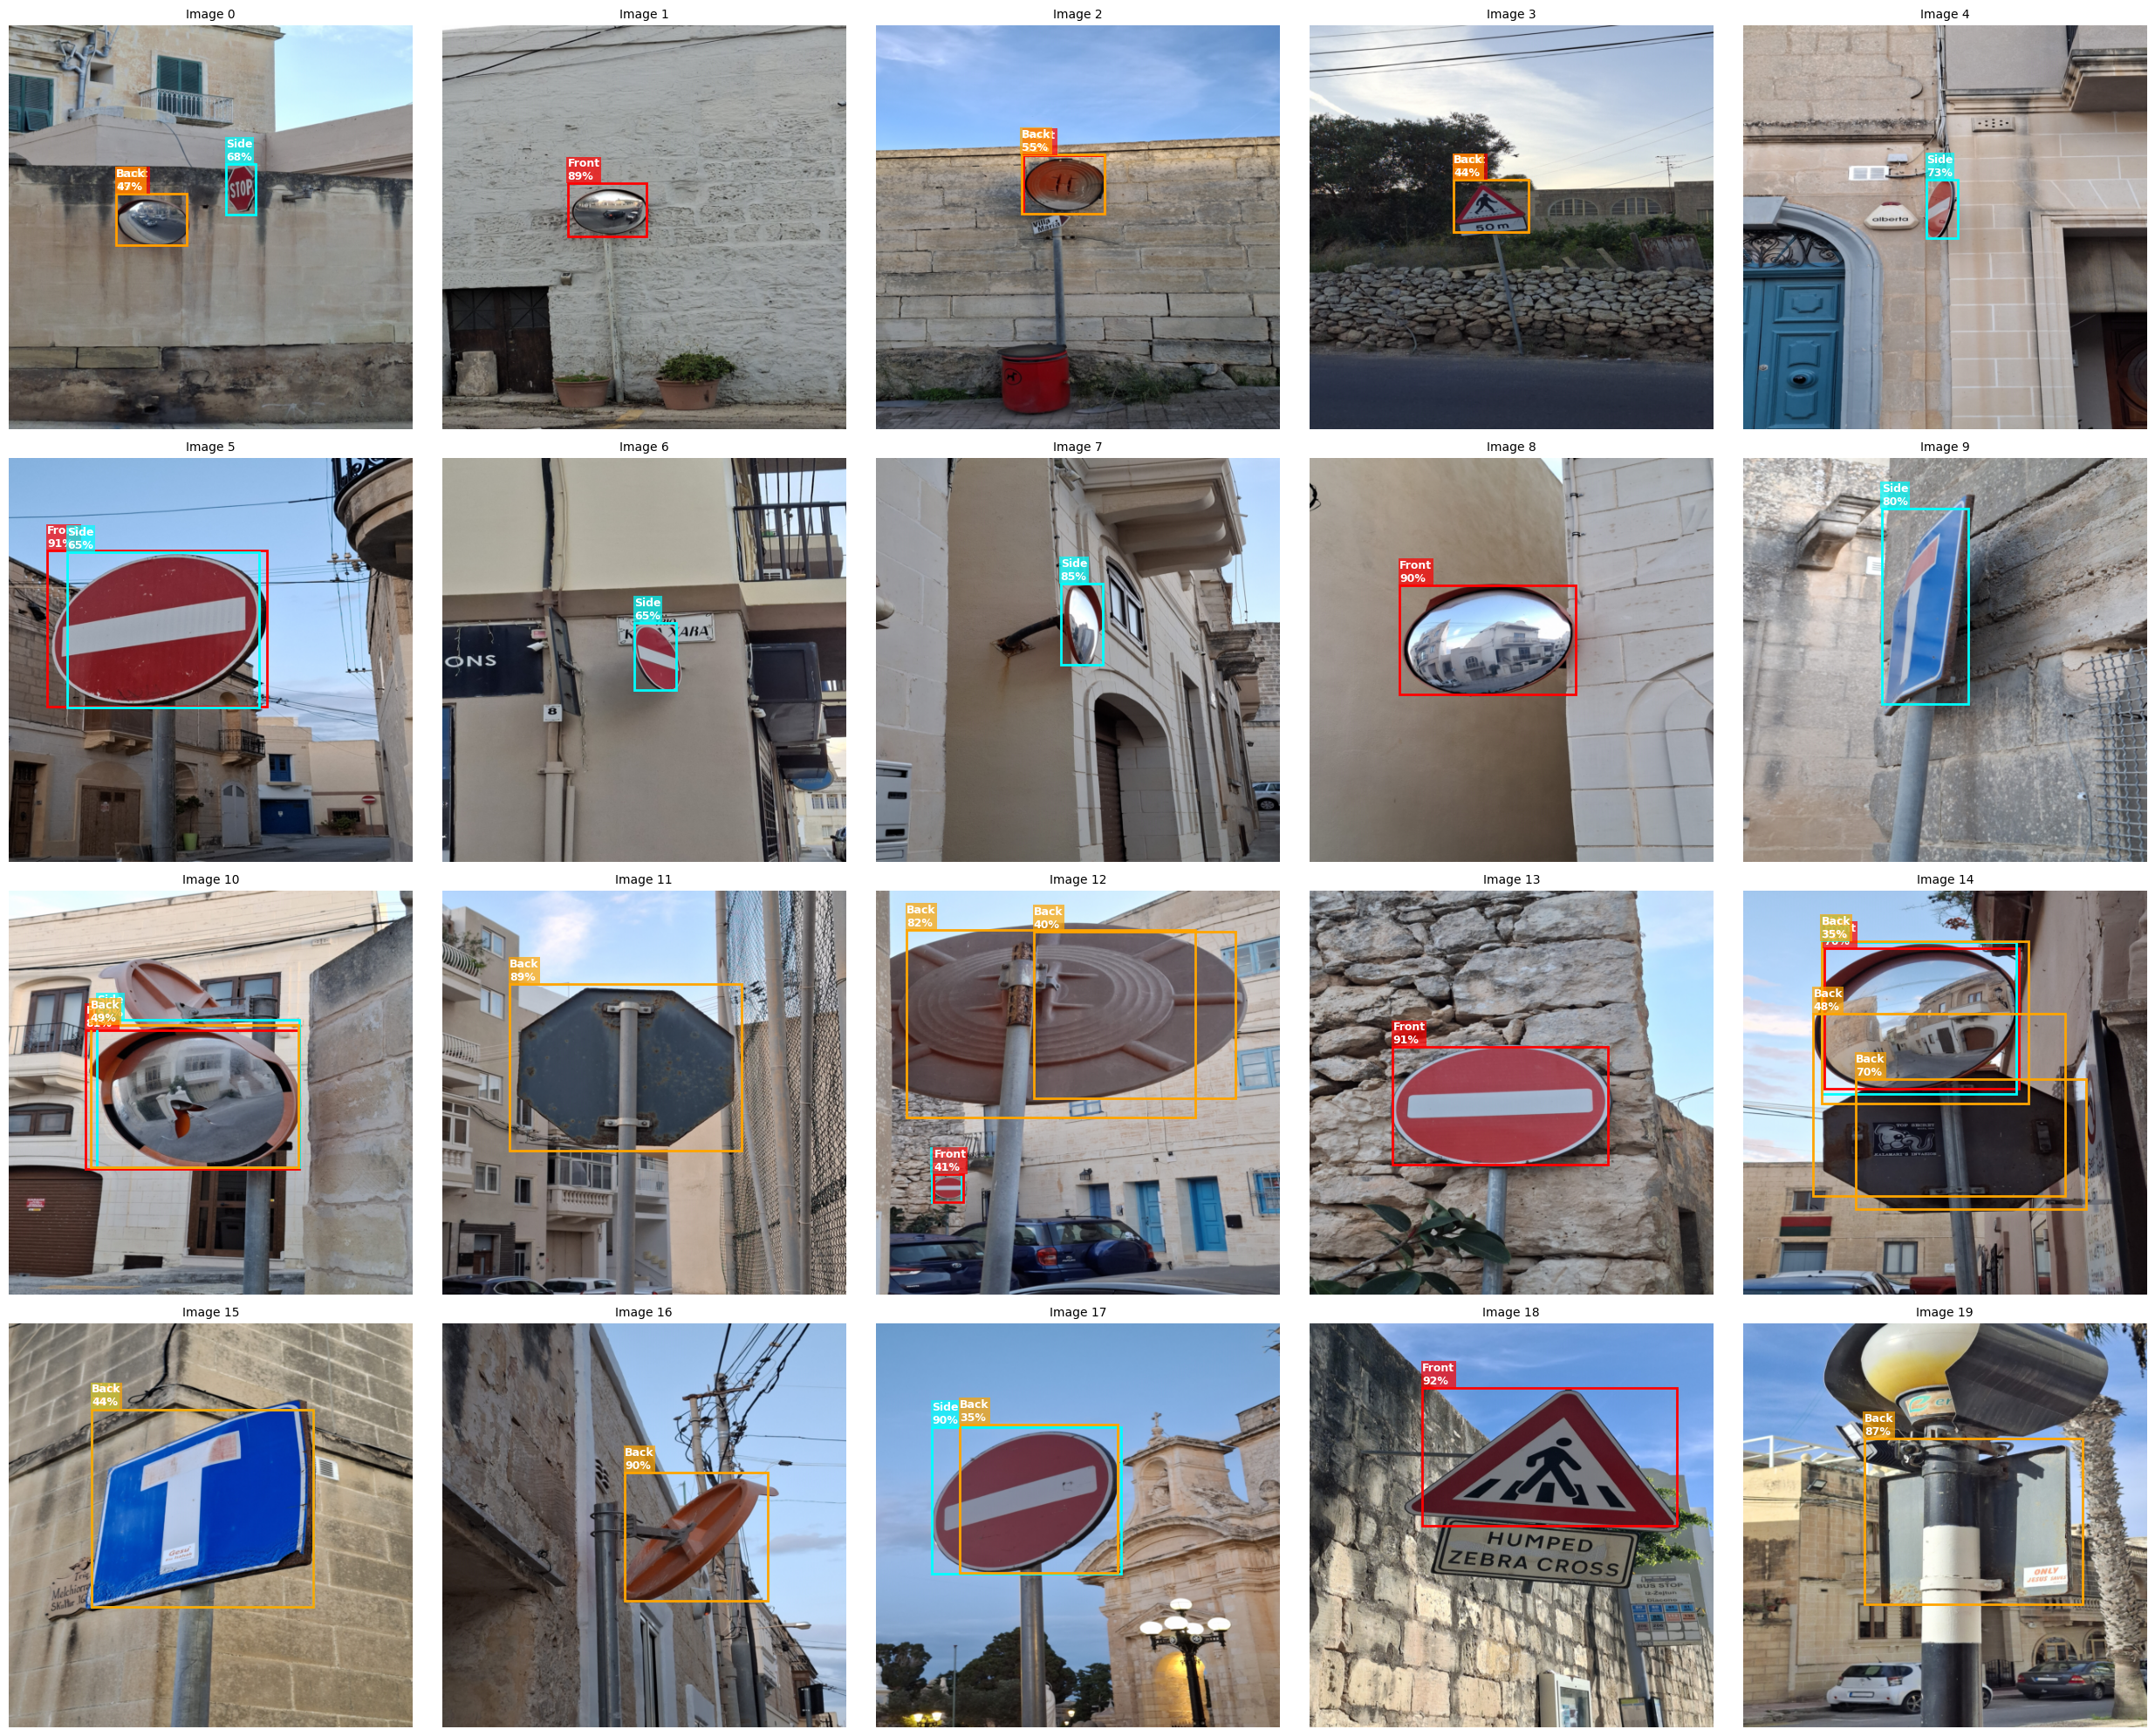

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
VAL_ROOT   = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\images\val'
VAL_ANN    = r'COCO-based_COCO_view_angle\COCO-based_COCO_view_angle\annotations\val.json'
MODEL_PATH = "runs/viewing_angle_final/best_model.pth"

# CORRECTED CLASSES (0=Background, 1=Back, 2=Front, 3=Side)
CLASSES = ["Background", "Back", "Front", "Side"]
CONF_THRESHOLD = 0.35  

# VISUALIZATION SETTINGS
IMAGES_PER_ROW = 5
MAX_IMAGES_TO_SHOW = 20 # Limit to 20 for memory safety. Set to None to show ALL.

# ==========================================
# 2. LOAD DATA
# ==========================================
class ComposeDetection:
    def __init__(self, transforms, target_size=(512, 512)):
        self.transforms = transforms
        self.target_size = target_size

    def __call__(self, image, target):
        image = ImageOps.exif_transpose(image)
        image = F.resize(image, self.target_size)
        for t in self.transforms:
            image = t(image)
        return image, target

def collate_fn(batch): return tuple(zip(*batch))

norm_transforms = [T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
val_dataset = CocoDetection(VAL_ROOT, VAL_ANN, transforms=ComposeDetection(norm_transforms))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# ==========================================
# 3. LOAD MODEL
# ==========================================
print(f"Loading Model from {MODEL_PATH}...")
config = get_efficientdet_config('tf_efficientdet_d0')
config.num_classes = 3 
config.image_size = (512, 512)

net = EfficientDet(config, pretrained_backbone=False)
net.class_net = HeadNet(config, num_outputs=config.num_classes)

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
bench = DetBenchTrain(net, config)
bench.load_state_dict(checkpoint, strict=False) 

model = DetBenchPredict(bench.model)
model.to(DEVICE)
model.eval()
print("Model loaded successfully.")

# ==========================================
# 4. GRID VISUALIZATION LOOP
# ==========================================
print("Running inference to collect results...")

visualization_data = [] # List to store (image_np, predictions)

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(val_loader):
        # Stop if we hit the limit
        if MAX_IMAGES_TO_SHOW and len(visualization_data) >= MAX_IMAGES_TO_SHOW:
            break
            
        images_stack = torch.stack([img.to(DEVICE) for img in images])
        outputs = model(images_stack)
        
        for i in range(len(images)):
            if MAX_IMAGES_TO_SHOW and len(visualization_data) >= MAX_IMAGES_TO_SHOW:
                break
                
            # Un-normalize image for display
            img_np = images[i].permute(1, 2, 0).cpu().numpy()
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
            
            # Store data
            visualization_data.append((img_np, outputs[i].cpu()))

# --- PLOTTING ---
num_images = len(visualization_data)
if num_images == 0:
    print("No images found.")
else:
    # Calculate rows needed
    num_cols = IMAGES_PER_ROW
    num_rows = math.ceil(num_images / num_cols)
    
    print(f"Plotting {num_images} images in a {num_rows}x{num_cols} grid...")

    # Create figure (adjust figsize height dynamically based on rows)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
    
    # Flatten axes array for easy iteration
    if num_rows == 1 and num_cols == 1: axes = [axes]
    elif num_rows == 1 or num_cols == 1: axes = axes.flatten()
    else: axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_images:
            img_np, preds = visualization_data[i]
            
            ax.imshow(img_np)
            
            # Draw Predictions
            for p in preds:
                x1, y1, x2, y2, score, cls = p.numpy()
                
                if score > CONF_THRESHOLD:
                    w, h = x2 - x1, y2 - y1
                    cls_id = int(cls)
                    c_name = CLASSES[cls_id]
                    
                    # Colors
                    if c_name == "Front": color = '#FF0000' # Red
                    elif c_name == "Side": color = '#00FFFF' # Cyan
                    else: color = '#FFA500' # Orange
                    
                    # Box
                    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)
                    
                    # Text
                    label_text = f"{c_name}\n{score:.0%}"
                    ax.text(x1, y1-5, label_text, color='white', fontsize=9, weight='bold', 
                            bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1))
            
            ax.set_title(f"Image {i}", fontsize=10)
            ax.axis('off')
        else:
            # Hide unused subplots
            ax.axis('off')

    plt.tight_layout()
    plt.show()